## Семинар 2 "Распознавание рукописных цифр"

ФИО: Филин Максим Дмитриевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [12]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [13]:
import torch
torch.__version__

'0.3.1'

In [4]:
# аугментация (scale, rotate)
# horizontal + vertical pixels for each example
# activation functions (combinations)
# NN architecture
# num epochs
# optimization algorithms 
# изменить batch_size

In [14]:
def view_samples(X, y):
    plt.figure(figsize=(6, 7))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title(y[i])
        plt.axis('off')

In [26]:
def get_loader_transform(transforms, batch_size=32, train=True):
    if train:
        dataset = MNIST('.', train=True, download=True, transform=transforms)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    else:
        dataset = MNIST('.', train=False, transform=basic_transform)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [16]:
def get_samples_from_loader(loader):
    X_total = np.array([])
    y_total = np.array([])
    for X, y in loader:
        if not X_total.shape[0]:
            X_total = X.numpy()
            y_total = y.numpy()[np.newaxis, :].T
        else:    
            X_total = np.vstack((X_total, X.numpy()))
            y_total = np.vstack((y_total, y.numpy()[np.newaxis, :].T))
    return X_total, y_total

In [17]:
pad_transform = transforms.Compose([
                       transforms.Pad(padding=5),
                       transforms.RandomCrop(size=(28, 28)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [19]:
train_loader_pad_transform = get_loader_transform(transforms=pad_transform, train=True)

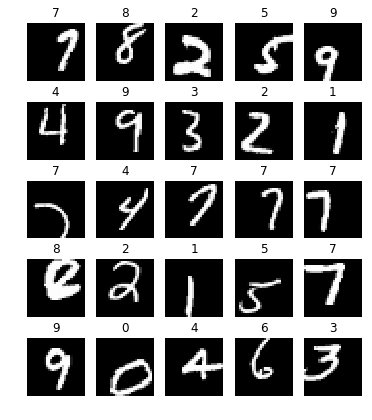

In [20]:
X_pad_batch, y_pad_batch = next(iter(train_loader_pad_transform))
view_samples(X_pad_batch.numpy(), y_pad_batch.numpy())

In [21]:
rhflip_transform = transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [22]:
train_loader_rhflip_transform = get_loader_transform(transforms=rhflip_transform, train=True)

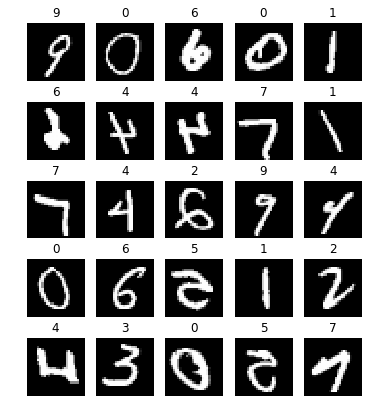

In [23]:
X_rhflip_batch, y_rhflip_batch = next(iter(train_loader_rhflip_transform))
view_samples(X_rhflip_batch.numpy(), y_rhflip_batch.numpy())

In [27]:
basic_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [28]:
train_loader = get_loader_transform(basic_transform, train=True, batch_size=32)
test_loader = get_loader_transform(basic_transform, train=False, batch_size=32)

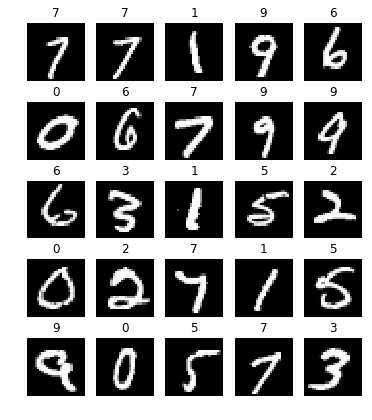

In [29]:
X_batch, y_batch = next(iter(train_loader))
view_samples(X_batch.numpy(), y_batch.numpy())

In [30]:
default_size = 28
alpha = 1.2
new_size = int (default_size * alpha)
scale_transform = transforms.Compose([
                       transforms.Scale(size=(new_size, new_size)),
                       transforms.CenterCrop(size=(default_size, default_size)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))           
                    ])

/home/maksim/Remote/venv36/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [31]:
train_loader_scale_transform = get_loader_transform(transforms=scale_transform, train=True, batch_size=32)

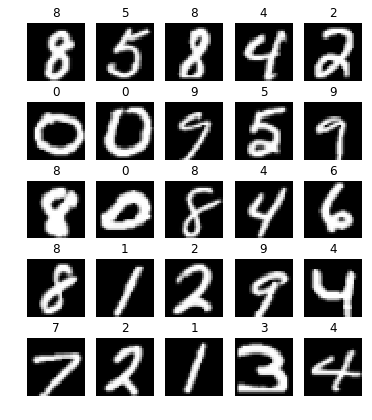

In [32]:
X_scale_batch, y_scale_batch = next(iter(train_loader_scale_transform))
view_samples(X_scale_batch.numpy(), y_scale_batch.numpy())

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [33]:
def train(network, epochs, learning_rate, samples_iterator):
    loss = NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in samples_iterator:
                X = X.view(X.size(0), -1).numpy() # X is 32*784 whre 32 is batch size
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [36]:
network = NeuralNetwork([Linear(784, 512), Sigmoid(),
               Linear(512, 512), Sigmoid(),
               Linear(512, 10)])

Epoch 2... (Train/Test) NLL: 0.235/0.195	Accuracy: 0.932/0.943

/home/maksim/Remote/venv36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


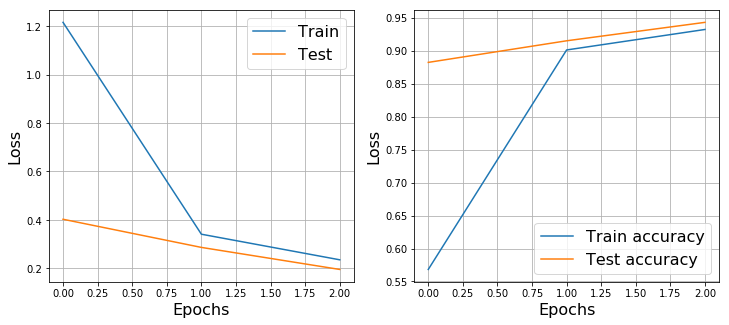

In [37]:
train(network, 100 , 0.1, train_loader) #appr. 50epochs

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [38]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = np.maximum(0, X)
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.s > 0) * dLdy
    
    def step(self, learning_rate):
        pass

In [39]:
class ELU:
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        self.s = self.alpha * (np.exp(X) - 1) * (X < 0) + X * (X >= 0)
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.s + self.alpha) * (self.X < 0) * dLdy + (self.X >= 0) * dLdy
    
    def step(self, learning_rate):
        pass

In [40]:
network_relu = NeuralNetwork([Linear(784, 512), ReLU(),
               Linear(512, 512), ReLU(),
               Linear(512, 10)])

Epoch 9... (Train/Test) NLL: 0.239/0.223	Accuracy: 0.928/0.934

/home/maksim/Remote/venv36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


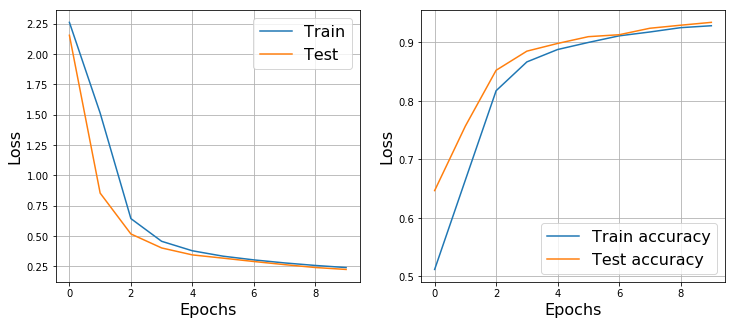

CPU times: user 1min 29s, sys: 1min 10s, total: 2min 39s
Wall time: 26.7 s


In [41]:
%time train(network_relu, 10, 0.01, test_loader) 

In [45]:
network_elu = NeuralNetwork([Linear(784, 512), ELU(0.1),
               Linear(512, 512), ELU(0.1),
               Linear(512, 10)])

Epoch 19... (Train/Test) NLL: 0.000/0.074	Accuracy: 1.000/0.986

/home/maksim/Remote/venv36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


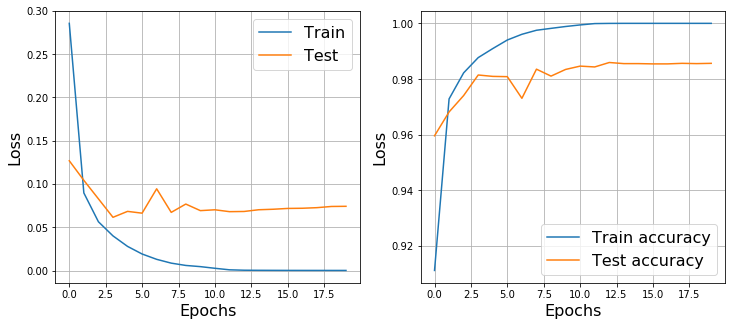

CPU times: user 15min 11s, sys: 12min 42s, total: 27min 54s
Wall time: 4min 39s


In [46]:
%time train(network_elu, 20, 0.1, train_loader) # 20-30 epochs

### Часть 3: Анализ ошибок

In [47]:
network = network_elu

In [49]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

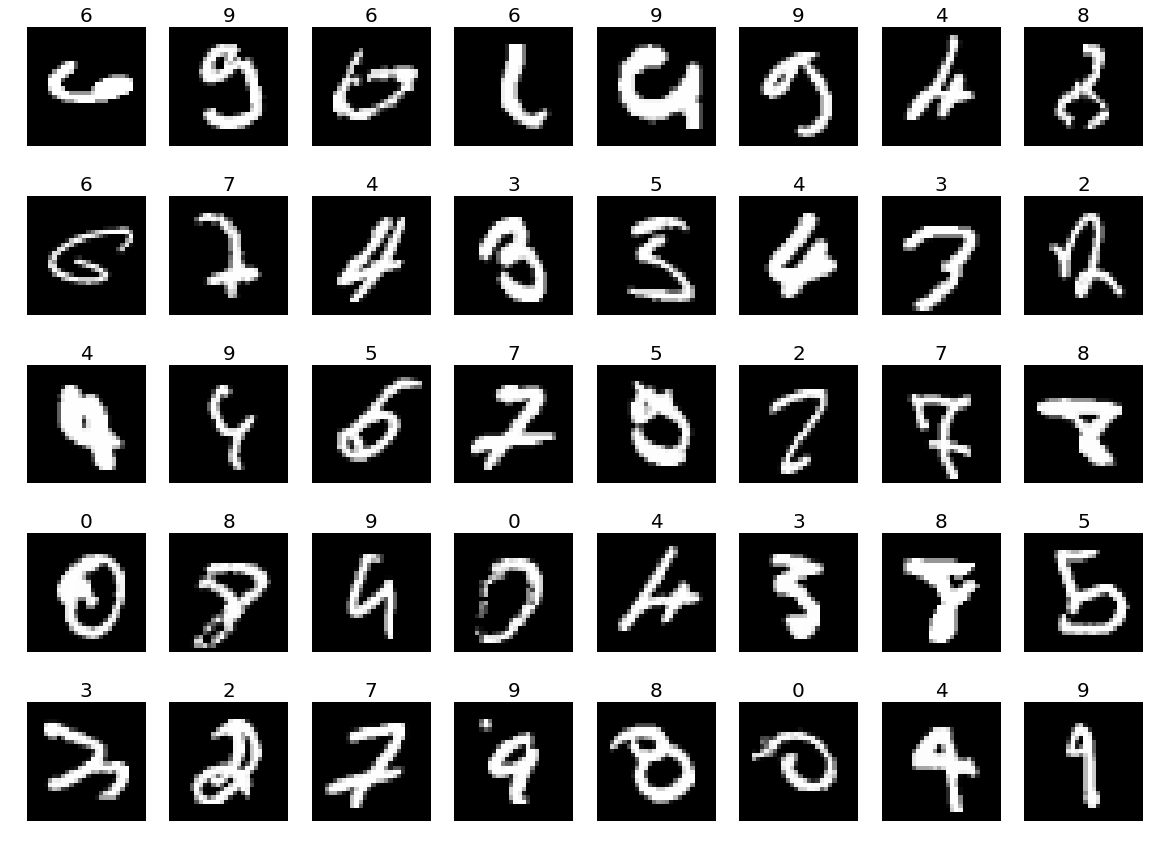

In [56]:
plt.figure(figsize=(20, 15))
order = np.argsort(logits)
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}'.format(correct_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Сигмоида обучается дольше, ReLU и ELU позволяет быстрее достичь хорошего качества на тестовых данных.
Предобработка не дала заметного улучшения.